In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
events_data = pd.read_csv('/Users/ganievanvar/Stepik/DataScience/Datasets/event_data_train.csv')

In [34]:
submissions_data = pd.read_csv('/Users/ganievanvar/Stepik/DataScience/Datasets/submissions_data_train.csv')

In [35]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [37]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [10]:
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [11]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [12]:
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [13]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [15]:
events_data['day'] = events_data.date.dt.date

In [16]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


<AxesSubplot:xlabel='day'>

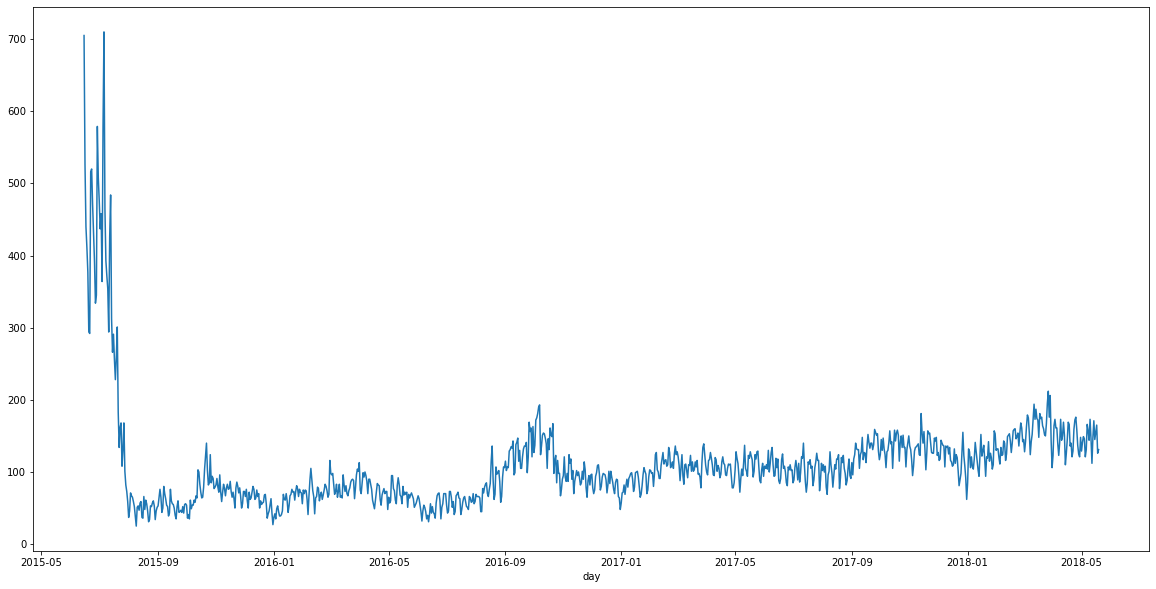

In [23]:
events_data.groupby('day').user_id.nunique().plot(figsize=(20,10))

<AxesSubplot:>

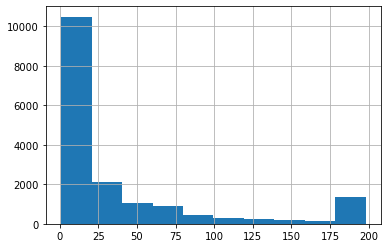

In [33]:
events_data[events_data.action == 'passed'] \
        .groupby('user_id', as_index=False) \
        .agg({'step_id' : 'count'}) \
        .rename(columns={'step_id' : 'passed_steps'}) \
        .passed_steps.hist()

In [96]:
users_events_data = events_data.pivot_table(index='user_id', \
                        columns='action', \
                        values='step_id', \
                        aggfunc='count', \
                        fill_value=0).reset_index()

In [97]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [40]:
users_scores = submissions_data.pivot_table(index='user_id', \
                        columns='submission_status', \
                        values='step_id', \
                        aggfunc='count', \
                        fill_value=0).reset_index()

In [41]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [51]:
# время между активностью пользователей
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
        .groupby('user_id')['timestamp'].apply(list) \
        .apply(np.diff).values

In [53]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [59]:
gap_data = gap_data / (24*60*60) # перерывы в днях между заходами на курсы

<AxesSubplot:>

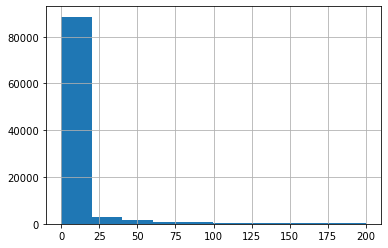

In [60]:
 gap_data[gap_data < 200].hist()

In [61]:
gap_data.quantile(0.95) # то есть только 5% пользователей возвращаются на курсе после 59 дней (2 месяца)

59.760440972222156

In [71]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [81]:
now = 1526772811
drop_out_threshold = 30*24*60*60

In [75]:
users_data = events_data.groupby('user_id', as_index=False).agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})

In [82]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [84]:
users_data.head(10)

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True
5,8,1481466913,True
6,9,1484999497,True
7,11,1526140625,False
8,14,1436368676,True
9,16,1513162585,True


In [85]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [90]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [94]:
users_data = users_data.fillna(0)

In [95]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [99]:
users_data = users_data.merge(users_events_data, how='outer')

In [101]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [102]:
users_days = events_data.groupby('user_id').day.nunique()

In [106]:
users_days = users_days.to_frame().reset_index()

In [107]:
users_days.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [108]:
users_data = users_data.merge(users_days, how='outer')

In [109]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [110]:
users_data.user_id.nunique()

19234

In [111]:
events_data.user_id.nunique()

19234

In [112]:
users_data['passed_course'] = users_data.passed > 170

In [114]:
users_data.head(10)

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
5,8,1481466913,True,9.0,21.0,109,84,37,156,2,False
6,9,1484999497,True,0.0,0.0,3,3,0,4,1,False
7,11,1526140625,False,0.0,0.0,1,0,1,1,1,False
8,14,1436368676,True,0.0,1.0,4,3,1,9,1,False
9,16,1513162585,True,77.0,106.0,196,196,108,651,21,True


In [115]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [116]:
1425 / 17809 * 100  # 8% прошли курс

8.001572238755687